<a href="https://colab.research.google.com/github/AabidMK/RealtyAI_Infosys_Internship_Aug2025/blob/Sarayu-Narra/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create a base model using linear regression and evaluate it performance.
Save results.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib  # for saving the model

In [ ]:
#Uploaded the dataset
df = pd.read_csv('/content/Real Estate Data V21.csv (1).zip')

In [ ]:
#Explored
print("Shape of dataset:", df.shape)
print(df.columns)
print(df.head())
print(df.info())
print(df.describe())

Shape of dataset: (14528, 9)
Index(['Name', 'Property Title', 'Price', 'Location', 'Total_Area',
       'Price_per_SQFT', 'Description', 'Baths', 'Balcony'],
      dtype='object')
                                      Name  \
0                         Casagrand ECR 14   
1    Ramanathan Nagar, Pozhichalur,Chennai   
2                              DAC Prapthi   
3  Naveenilaya,Chepauk, Triplicane,Chennai   
4                 VGN Spring Field Phase 1   

                                      Property Title     Price  \
0  4 BHK Flat for sale in Kanathur Reddikuppam, C...  ₹1.99 Cr   
1  10 BHK Independent House for sale in Pozhichal...  ₹2.25 Cr   
2      3 BHK Flat for sale in West Tambaram, Chennai   ₹1.0 Cr   
3  7 BHK Independent House for sale in Triplicane...  ₹3.33 Cr   
4              2 BHK Flat for sale in Avadi, Chennai   ₹48.0 L   

                                   Location  Total_Area  Price_per_SQFT  \
0             Kanathur Reddikuppam, Chennai        2583          7700.0

In [ ]:
# Drop rows with missing values (basic handling)
df = df.dropna()

In [ ]:
print(df.columns.tolist())

['Name', 'Property Title', 'Price_lakh', 'Location', 'Total_Area', 'Price_per_SQFT', 'Description', 'Baths', 'Balcony']


In [ ]:
# Replace 'price' with the correct column name in your dataset
target_col = 'Price_lakh'

# Automatically selecting numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude the target from features
feature_cols = [col for col in numerical_cols if col != target_col]

# Split features and target
X = df[feature_cols]
y = df[target_col]

In [ ]:
#Splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# Drop rows where target is NaN
df = df.dropna(subset=['Price_lakh'])

# Define features and target again
X = df[feature_cols]
y = df['Price_lakh']

In [ ]:
print(df['Price_lakh'].isna().sum())   # should be 0
print(df['Price_lakh'].head(20))

0
Series([], Name: Price_lakh, dtype: float64)


In [ ]:
print(df.shape)

(0, 9)


In [ ]:
#Training Linear Regression Mode.
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 163.5250022643423
R-squared: 0.966812238070339


In [ ]:
# Save the trained model
joblib.dump(model, 'linear_regression_model.pkl')

# Save predictions vs actuals for inspection
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df.to_csv('base_model_predictions.csv', index=False)

print("Model and predictions saved successfully.")

Model and predictions saved successfully.


Modified CODE Adding Outliers

In [ ]:
import pandas as pd
import numpy as np
import re

# Load dataset
df = pd.read_csv('/content/Real Estate Data V21.csv (1).zip')
df.head()

# Clean and convert price column to Lakhs
def convert_price_to_lakh(Price):
    if isinstance(Price, str):
        Price = Price.strip().lower()
        if 'cr' in Price:
            return float(re.sub('[^0-9.]', '', Price)) * 100
        elif 'lakh' in Price:
            return float(re.sub('[^0-9.]', '', Price))
    return np.nan

df['Price_lakh'] = df['Price'].apply(convert_price_to_lakh)


In [ ]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal on numerical columns
for col in ['Price_lakh', 'Total_Area', 'Baths']:
    if col in df.columns:
        df = remove_outliers_iqr(df, col).reset_index(drop=True)

In [ ]:
# Split location into city and locality
df[['location_locality', 'location_city']] = df['Location'].str.split(',', n=1, expand=True)
df['location_locality'] = df['location_locality'].str.strip()
df['location_city'] = df['location_city'].str.strip()

In [ ]:
#Extract BHK from Property Title

def extract_bhk(value):
    match = re.search(r'(\d+)', str(value))
    if match:
        return int(match.group(1))
    return np.nan

df['bhk'] = df['bhk'].apply(extract_bhk) if 'bhk' in df.columns else df['Property Title'].apply(extract_bhk)

In [ ]:
num_cols = ['Price_lakh', 'Total_Area', 'Baths']

num_cols = [col for col in num_cols if col in df.columns]

# Log transform
for col in num_cols:
    df[f'{col}_log'] = np.log1p(df[col])

In [ ]:
from sklearn.model_selection import KFold

# target encoding
def target_encode(train_series, target, min_samples=1):
    means = train_series.groupby(train_series).apply(
        lambda x: target[x.index].mean() if len(x) >= min_samples else target.mean()
    )
    return train_series.map(means)

df['location_city_te'] = target_encode(df['location_city'], df['Price_lakh'])
df['location_locality_te'] = target_encode(df['location_locality'], df['Price_lakh'])

In [ ]:
from sklearn.preprocessing import StandardScaler

log_cols = [f'{col}_log' for col in num_cols]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[log_cols])
scaled_df = pd.DataFrame(scaled_features, columns=[f'{col}_scaled' for col in log_cols])

df = pd.concat([df, scaled_df], axis=1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
features = ['location_city_te', 'location_locality_te'] + [f'{col}_scaled' for col in log_cols]
X = df[features].dropna()
y = df.loc[X.index, 'Price_lakh']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f} Lakhs")
print(f"R² Score: {r2:.2f}")

RMSE: 12.79 Lakhs
R² Score: 0.97


Compare the evaluation on both train and test sets

In [ ]:
# Predictions on train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train set evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# Test set evaluation
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

print("📊 Model Evaluation")
print("-----------------------------")
print(f"Train RMSE: {train_rmse:.2f} Lakhs")
print(f"Train R² Score: {train_r2:.2f}")
print("-----------------------------")
print(f"Test RMSE:  {test_rmse:.2f} Lakhs")
print(f"Test R² Score:  {test_r2:.2f}")


📊 Model Evaluation
-----------------------------
Train RMSE: 13.66 Lakhs
Train R² Score: 0.96
-----------------------------
Test RMSE:  12.79 Lakhs
Test R² Score:  0.97


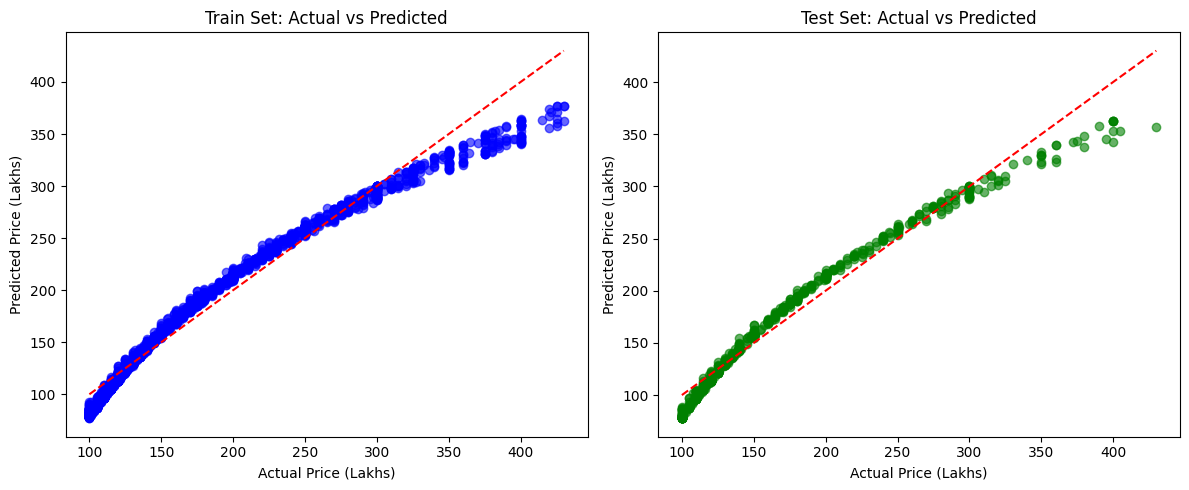

In [ ]:
import matplotlib.pyplot as plt

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plot
plt.figure(figsize=(12,5))

# --- Train set ---
plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual Price (Lakhs)")
plt.ylabel("Predicted Price (Lakhs)")
plt.title("Train Set: Actual vs Predicted")

# --- Test set ---
plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price (Lakhs)")
plt.ylabel("Predicted Price (Lakhs)")
plt.title("Test Set: Actual vs Predicted")

plt.tight_layout()
plt.show()

Constraint Matching

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initial list of numerical columns to consider for scaling
initial_numerical_cols = ['Total_Area', 'BHK', 'Price_Lakhs', 'City_Target_Encoded', 'Location_Name_Target_Encoded']

# List to store columns to be scaled
numerical_cols_to_scale = []

# Apply log transformation to skewed features (assuming Total_Area and Price_Lakhs might be skewed)
for col in ['Total_Area', 'Price_Lakhs']:
    if col in df.columns:
        try:
            # Add a small constant to handle potential zero values before log transformation
            df[f'{col}_log'] = np.log1p(df[col])
            numerical_cols_to_scale.append(f'{col}_log')
            print(f"Log transformation applied to '{col}'.")
        except Exception as e:
            print(f"Could not apply log transformation to '{col}': {e}")
            # If log transformation fails, use the original column if it's in the initial list
            if col in initial_numerical_cols:
                numerical_cols_to_scale.append(col)
    else:
        print(f"Column '{col}' not found in DataFrame for log transformation.")
        # If column is missing, skip it

# Add other initial numerical columns that were not log-transformed
for col in initial_numerical_cols:
    if col not in ['Total_Area', 'Price_Lakhs'] and col in df.columns:
        numerical_cols_to_scale.append(col)


# Select the numerical columns for scaling, including potentially log-transformed ones
# Ensure selected columns are actually numerical and exist in the DataFrame
numerical_features_for_scaling = df[numerical_cols_to_scale].select_dtypes(include=np.number)


numerical_features_for_scaling.replace([np.inf, -np.inf], np.nan, inplace=True)
numerical_features_for_scaling.fillna(numerical_features_for_scaling.mean(), inplace=True)


# Instantiate and fit the StandardScaler
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features_for_scaling)

# Create a new DataFrame with scaled numerical features
scaled_df = pd.DataFrame(scaled_numerical_features, columns=[f'{col}_scaled' for col in numerical_features_for_scaling.columns])
# Ensure index alignment
# Drop original numerical columns that were scaled before concatenating
df = df.drop(columns=numerical_features_for_scaling.columns, errors='ignore')
df = pd.concat([df, scaled_df], axis=1)


display(df.head())

Log transformation applied to 'Total_Area'.
Column 'Price_Lakhs' not found in DataFrame for log transformation.


,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony,Price_lakh,Total_Area_log_scaled
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes,199.0,0.594775
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes,225.0,2.134744
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No,100.0,-0.441872
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes,333.0,1.363923
4,DRA 90 Degrees,"3 BHK Flat for sale in Pallikaranai, Chennai",₹1.3 Cr,"Rose Avenue, Pallikaranai,Chennai",1444,9000.0,Looking for a 3 BHK Apartment for sale in Chen...,3,No,130.0,-0.303250


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
# X should be the scaled numerical columns excluding the scaled target variable
scaled_numerical_cols = [col for col in df.columns if col.endswith('_scaled')]
# Remove the target variable from the feature list
if 'Price_Lakhs_log_scaled' in scaled_numerical_cols:
    scaled_numerical_cols.remove('Price_Lakhs_log_scaled')
elif 'Price_Lakhs_scaled' in scaled_numerical_cols:
     scaled_numerical_cols.remove('Price_Lakhs_scaled')


X = df[scaled_numerical_cols]
# The target variable is the scaled price
y = df['Price_Lakhs_log_scaled']


# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

KeyError: 'Price_Lakhs_log_scaled'

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

print("Linear Regression model trained successfully.")

Linear Regression model trained successfully.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")